# Perceptrón de Hinton
### Descripción General del Práctico
En este práctico, exploraremos la implementación y el entrenamiento de un modelo Perdeptrón de Hinton para generación de imágenes. Usaremos los datasets [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) y [FashionMNIST](https://en.wikipedia.org/wiki/Fashion_MNIST).

### Objetivo del Práctico
El objetivo de este práctico es endender cómo se implementa y entrena el Perceptrón presentado por Hinton para generación de imágenes.

### Imports

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import time
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm

### Seteo de Device

Seteamos sobre que dispositivo vamos a estar corriendo el entrenamiento e inferencia.

In [2]:
DEVICE = torch.device(
    'cuda:0' if torch.cuda.is_available() else 
    'mps' if torch.backends.mps.is_available() else 
    'cpu'
)
print(DEVICE)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

cuda:0


### Transformaciones:

Creamos la transformación para binarizar nuestro dataset. Esto va a hacer que pasemos de $[0, 256]$ a $\{0, 1\}$. A su vez agregamos la transformación trabajar con tensores.

In [3]:
class BinarizedTransform:
    def __call__(self, img):
        return (img > .5).float()
    
img_transforms = transforms.Compose([transforms.ToTensor(), BinarizedTransform()])
img_shape = (28,28)
img_size = 28*28*1
num_classes = 10

### Dataset

Vamos a estar trabajando con el dataset de [MNIST](https://es.wikipedia.org/wiki/Base_de_datos_MNIST) que nos brinda imágenes de 28*28 de dígitos escritos a mano.

Para la generación vamos a estar trabajando únicamente con un solo dígito. Vamos a setearlo en este momento y continuamos trabajando con este.

In [4]:
labels_used = [1]

### Carga de datos y creación de Dataloader.

In [5]:
BATCH_SIZE = 64

download_dataset = True # If you already have the dataset you could use False

train_data = datasets.MNIST(root='mnist/', train=True, transform=img_transforms, download=download_dataset)
train_data = [(image, label) for image, label in train_data if labels_used and label in labels_used]

train_dataloader = DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)


In [6]:
print(f"Train dataset size: {len(train_data)}")

Train dataset size: 6742


### Exploración del Dataset

In [7]:
def show_images(images, title="MNIST Images"):
    n = len(images)
    if n == 0:
        print("No images to show")
        return

    rows = max(1, int(math.floor(math.sqrt(n))))
    columns = int(math.ceil(n / rows))

    fig, axs = plt.subplots(rows, columns, figsize=(columns * 2, rows * 2))
    fig.suptitle(title, fontsize=14, y=.95)

    # Normalize axs to a 2D array so we can always index [i, j]
    if rows == 1 and columns == 1:
        axs = np.array([[axs]])
    elif rows == 1 or columns == 1:
        axs = np.atleast_2d(axs)
        axs = axs.reshape(rows, columns)

    for i in range(rows):
        for j in range(columns):
            index = i * columns + j
            ax = axs[i, j]
            ax.axis('off')
            if index < n:
                img = images[index]
                if isinstance(img, torch.Tensor):
                    img = img.cpu().numpy()
                img = np.squeeze(img)
                ax.imshow(img, cmap='gray')

    plt.show()
    plt.close(fig)

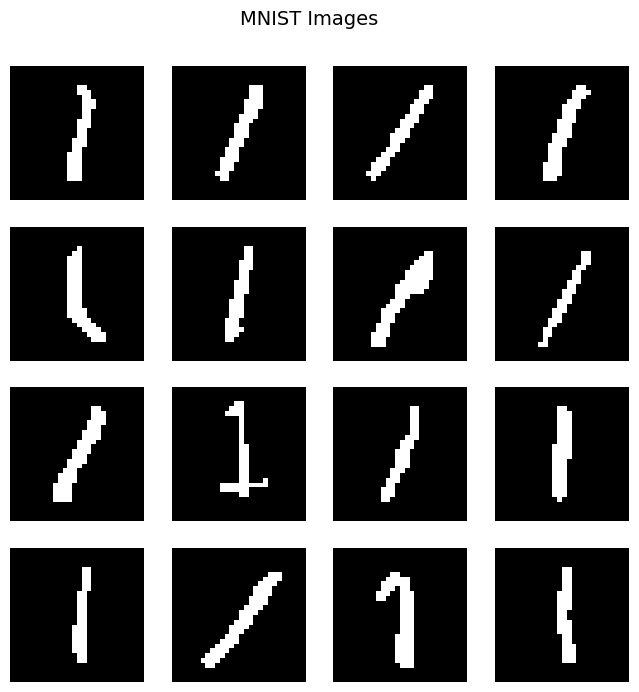

In [8]:
images = []
for _ in range(16):
    image, label = train_data[random.randrange(len(train_data))]
    images.append(image.reshape(img_shape))
show_images(images)

### Definicion de Hinton Perceptron

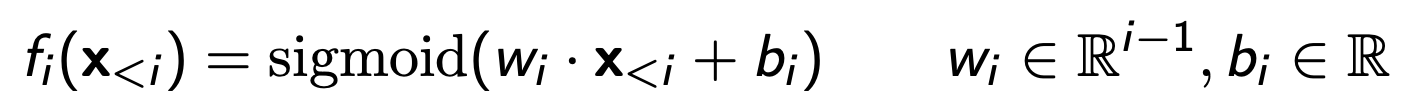

Para replicar esto usaremos una máscara que deje a todos los pesos que "ven el futuro" no afecten la predicción.
Revisar [torch.tril](https://docs.pytorch.org/docs/stable/generated/torch.tril.html). No se olviden de la diagonal!

In [9]:
ones = torch.ones((3,3))

masked_ones = torch.tril(ones)
print(ones)
print(masked_ones.T)
print(ones * masked_ones.T)

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])
tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])


### ¿Qué resultado debería dara la multiplicación de ones . masked_ones.T?

##### *Respuesta*
Para este caso como buscamos mantener solo los valores por encima de la diagonal, es coherente lo que nos da.
Si hubieramos usado **@** o **matmul** para realizar una multiplicacion matricial, en vez de elemento a elemento.
El resultado sería: ([1,2,3],[1,2,3],[1,2,3]). Que no es lo que buscamos.
Esto se debe a que el **torch.matmul**, resultará en una matriz de 3x3 donde los elementos de una misma columna, serán el producto de los mismos dos vectores. 
**Por ejemplo:** para j=0 o la primer columna. La multiplicación de vectores será siempre [1,1,1] x [1,0,0]. Por lo que la primer columna de la matriz resultante, será toda de unos. 
Para la segunda columna se cumple: [1,1,1] x [1,1,0] = 2 y para la tercera [1,1,1] x [1,1,1] = 3.

Recomendamos usar [nn.Parameter](https://docs.pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) para la definición de los pesos y del bias.

In [10]:
# Máscara de ejemplo
example_mask = torch.tril(torch.ones(img_shape))
print(example_mask[0:2])

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [11]:
class HintonPerceptron(nn.Module):
    def __init__(
        self,
        input_size: int,
        img_shape: tuple[int, int]
    ):
        super(HintonPerceptron, self).__init__()
        self.img_shape = img_shape
        self.img_size = torch.prod(torch.tensor(img_shape)).item()

        # Inicializamos pesos W
        self.w = nn.Parameter(torch.randn((input_size, input_size)))

        # Guardamos la máscara, como no es un parámetro entrenable la registramos como buffer. Así se mueve al dispositivo con el modelo
        self.register_buffer('mask', torch.tril(torch.ones(input_size, input_size)))

        # Inicializamos bias b
        self.bias = nn.Parameter(torch.randn((1, input_size)))
        
    def forward(
        self,
        x: torch.Tensor
    ):
        # Aplicamos la máscara a w para no usar pesos futuros
        w_masked = self.w * self.mask

        # Multiplicamos x . w^T (w transpuesta)
        x_w = x @ w_masked.T

        # Sumamos el bias
        logits = x_w + self.bias
        
        # Aplicamos la función de activación y retornamos
        return torch.sigmoid(logits)
    
    def generate_x(
        self,
        num_images: int
    ):
        # Usamos torch.no_grad() porque no necesitamos gradientes para generar imágenes
        with torch.no_grad():
            # Generamos imágenes de tamaño num_images x img_size
            # Para cada píxel
            # Obtenemos la salida de la red basada en los pixeles generadas hasta ahora
            # Muestreamos una distribución Bernoulli para obtener el valor del píxel
            # Retornamos las imágenes generadas (en formato de imagen, precisamos redimensionar)
            device = next(self.parameters()).device
            # Aseguramos que la máscara y bias estén en el dispositivo correcto
            w_masked = (self.w * self.mask).to(device)
            bias = self.bias.to(device)

            imgs = torch.zeros((num_images, self.img_size), device=device)

            # Generamos secuencialmente cada píxel condicionado a los anteriores
            for i in range(self.img_size):
                logits = imgs @ w_masked + bias  # shape: (num_images, input_size)
                probs = torch.sigmoid(logits[:, i])  # prob de pixel i para cada imagen
                samples = torch.bernoulli(probs)
                imgs[:, i] = samples

            # Retornamos reshaped a (num_images, H, W)
            return imgs.view(num_images, *self.img_shape)

### Creación del modelo y seteo de Hyper-parámetros
En esta sección del código, se crea el modelo.

Y se eligen arbitrariamente los siguientes hyper-parámetros:
- learning rate (lr)
- cantidad de épocas (epochs)
- optimizador (optim)

In [12]:
lr = 1e-3
epochs = 300
criterion = nn.BCELoss() # función de pérdida

model = HintonPerceptron(
    input_size = 28*28,
    img_shape = (28,28)
).to(DEVICE)

optim = torch.optim.Adam(model.parameters(), lr=lr)

¿Por qué eligió usar esa función de pérdida?

### Proceso de entrenamiento del modelo
En esta celda, se define el entrenamiento del modelo utilizando un conjunto de datos de entrenamiento.

El código optimiza los parámetros del modelo minimizando la función de pérdida previamente definida a través de un optimizador.

In [13]:
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    n_epochs: int,
    train_loader: DataLoader,
    optim: torch.optim.Optimizer,
    print_epoch: int = 1
):
    for epoch in tqdm(range(n_epochs)):
        start_time = time.time()
        learning_error = 0
        for img, _ in train_loader:
            # Aplanamos la imagen y la movemos al dispositivo correspondiente
            x = torch.flatten(img, start_dim=1).to(DEVICE)
    
            # Reseteamos los gradientes
            optim.zero_grad()

            # Hacemos la predicción
            preds = model(x)

            # Calculamos la loss
            loss = nn.BCELoss()(preds, x)

            # Hacemos backprop
            loss.backward()

            # Optimizamos
            optim.step()

            learning_error += loss.item()

        if epoch%print_epoch == 0:
            imgs = model.generate_x(12).cpu()
            show_images(imgs, f"Generated images on epoch {epoch+1}")
            print(f"Epoch: {epoch+1} - duration {time.time()-start_time:.3f}s- error: {learning_error/len(train_loader):.3f}")

    return model

¿Por qué no usamos los valores de `y` que tiene el dataset? ¿No nos afecta esto al calcular la loss?

### Entrenamos el modelo!

  0%|          | 0/300 [00:00<?, ?it/s]

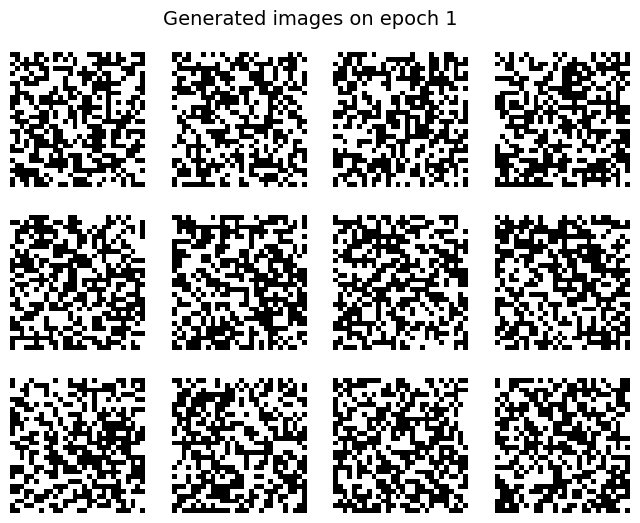

  1%|          | 2/300 [00:00<01:37,  3.06it/s]

Epoch: 1 - duration 0.613s- error: 1.670


 33%|███▎      | 100/300 [00:14<00:24,  8.33it/s]

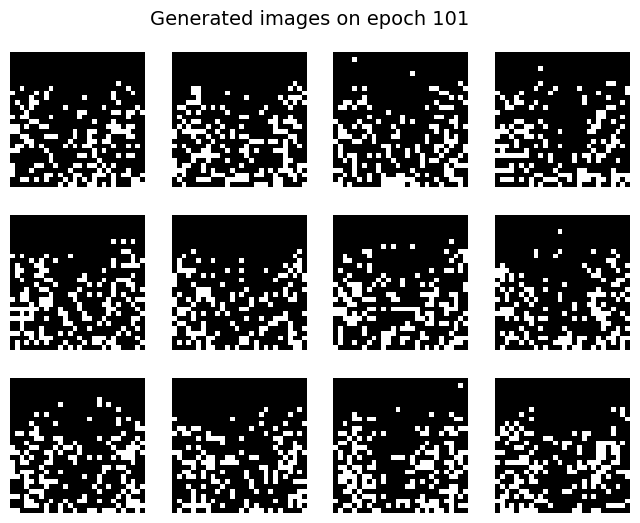

 34%|███▍      | 102/300 [00:14<00:29,  6.64it/s]

Epoch: 101 - duration 0.250s- error: 0.005


 67%|██████▋   | 200/300 [00:26<00:11,  8.46it/s]

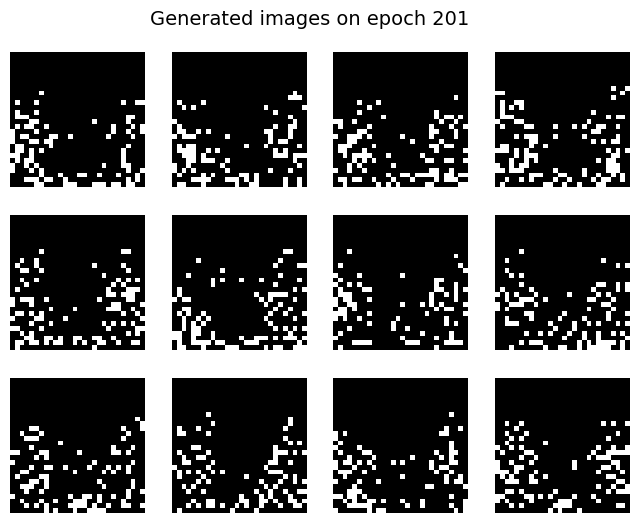

 67%|██████▋   | 202/300 [00:26<00:16,  6.07it/s]

Epoch: 201 - duration 0.343s- error: 0.000


100%|██████████| 300/300 [00:38<00:00,  7.77it/s]


In [14]:
trained_model = train_model(
    model=model,
    criterion=criterion,
    n_epochs=int(epochs),
    train_loader=train_dataloader,
    optim=optim,
    print_epoch=100
)

### Probamos el modelo generando imagenes

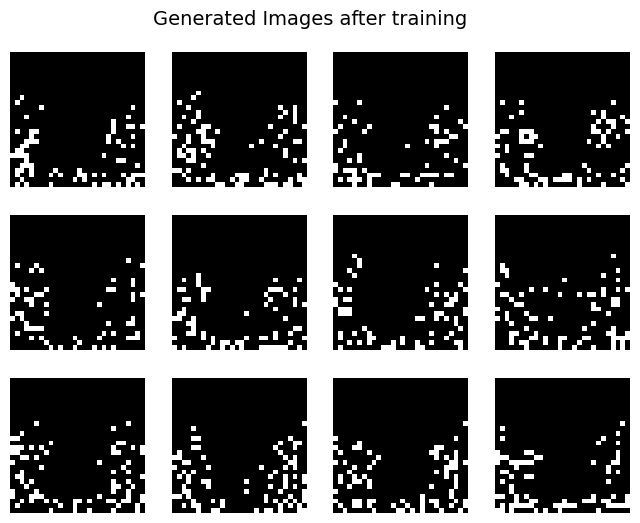

In [15]:
imgs = model.generate_x(12).cpu()
show_images(imgs, "Generated Images after training")

## Ejercicios:
1) Complete el código del perceptrón de Hinton.
2) Entrene el modelo utilizando 1 dígito.
3) Entrene el modelo utilizando al menos 3 dígitos.
4) Compare resultados. ¿Qué diferencias observas?
5) Entrene el modelo con el dataset de [FashionMNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html).
6) Compare y comente sobre los resultados obtenidos.